In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
%matplotlib inline


i think implementation of MIMO is simple. should take the input array and the parameter array .. as of now assume that all the model strucures are same. later I  will improve the code , by allowing different model structures for inputs

In [29]:
import matplotlib.pyplot as plt

In [30]:
import os 
dir_path = os.getcwd()


In [31]:
dir_path

'D:\\anaconda\\mpc'

In [32]:
import pandas as pd
df = pd.read_csv(dir_path + os.sep+ "data" + os.sep + "test.csv",header = [0,1,2])



dataframe interpolation only fills missing values .. numpy interpolation only applicable for 1d and returns only descrete values. scipy interpolation returns functions , but maybe slower.

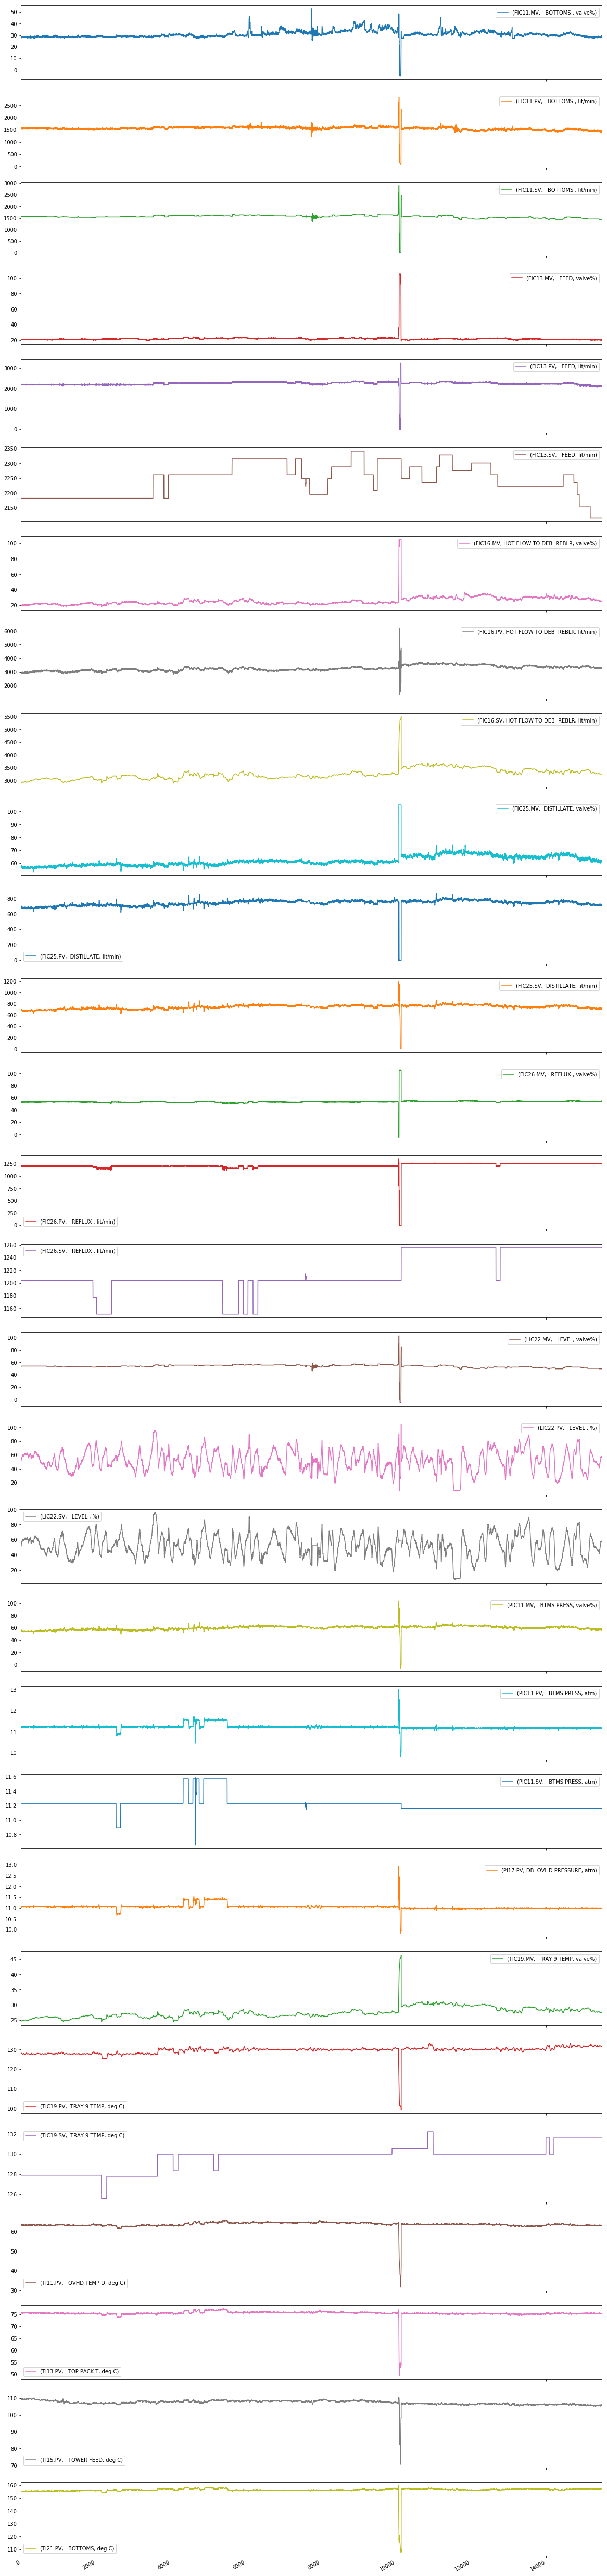

In [33]:
df.plot(subplots=True, figsize=(20, 100));

#### let us zoom in from sample numbers 10000 to 120000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CE47151630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001CE46A7B9B0>], dtype=object)

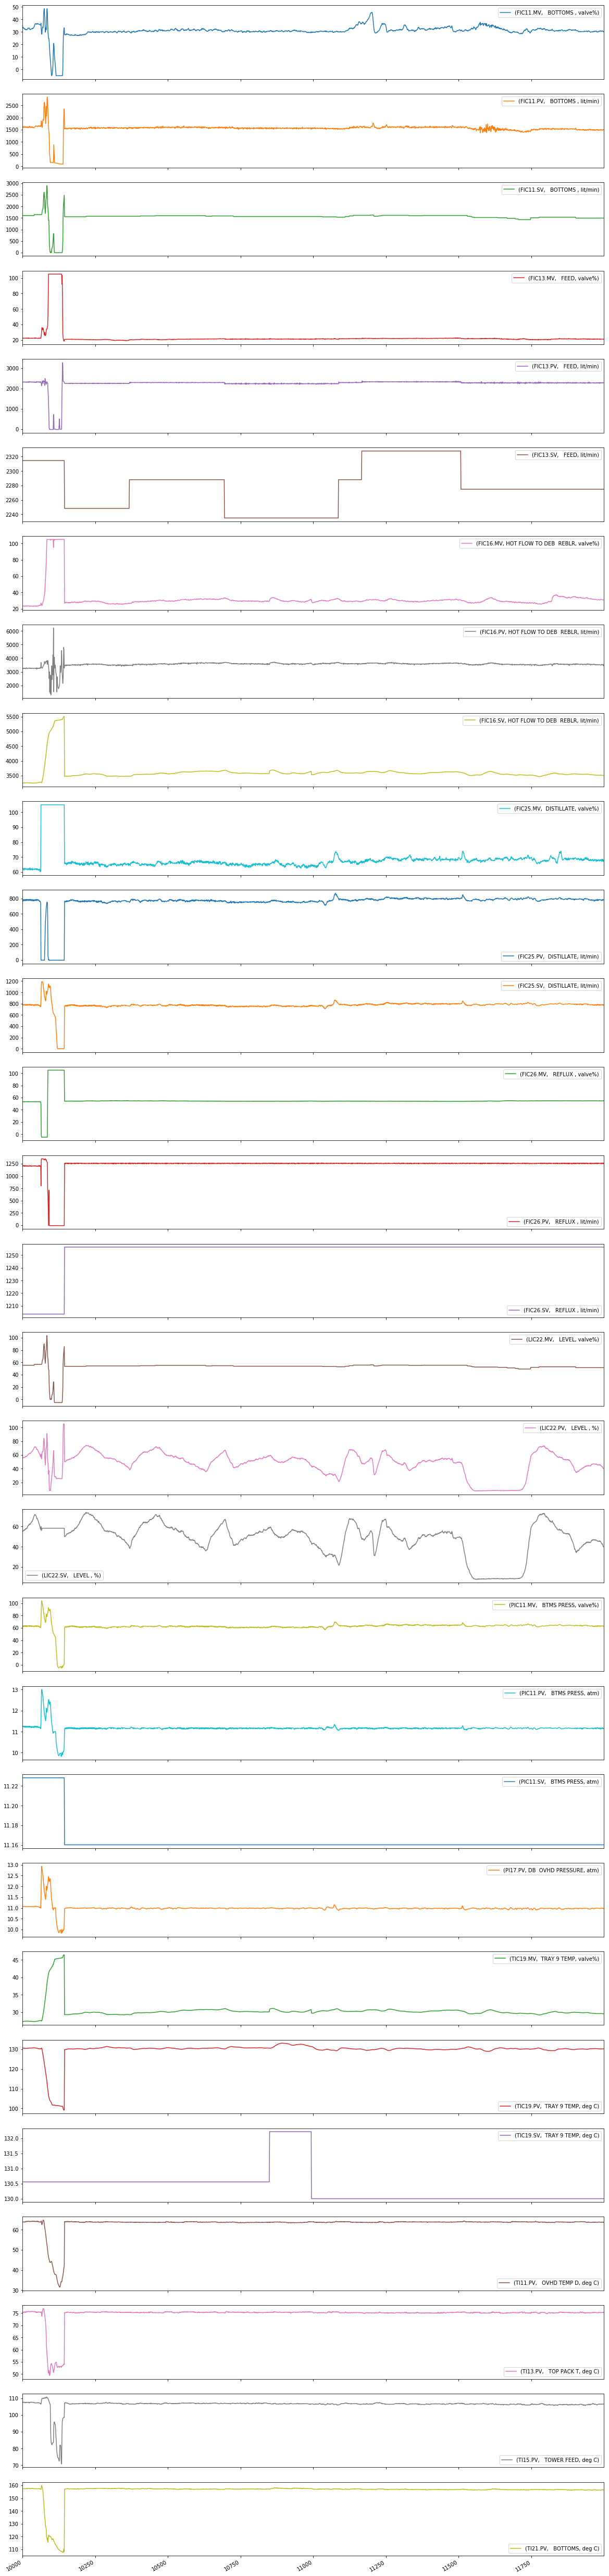

In [34]:
df[10000:12000].plot(subplots=True,figsize=(20,100))

In [35]:
### Do not consider the SV and the OP while calculating the std for bad data . Consider only the PV 

In [36]:
SV_suffixes = ['SP','SV','SPT']
PV_suffixes =['PV','MEAS']
OP_suffixes = ['OP','MV']


In [37]:
tags = df.columns.tolist()


In [38]:
tag_names , tag_descriptions,tag_units = zip(*tags)

In [39]:
def get_parameter_type(tag_names):
    parameters = []
    for name in tag_names:
        if '.PV' in name:
            parameters.append('PV')
        elif '.SP' in name:
            parameters.append('SP')
        elif '.OP' in name:
            parameters.append('OP')
        else :
            parameters.append('others')
    return parameters

In [40]:
parameters = get_parameter_type(tag_names)

In [41]:
parameters

['others',
 'PV',
 'others',
 'others',
 'PV',
 'others',
 'others',
 'PV',
 'others',
 'others',
 'PV',
 'others',
 'others',
 'PV',
 'others',
 'others',
 'PV',
 'others',
 'others',
 'PV',
 'others',
 'PV',
 'others',
 'PV',
 'others',
 'PV',
 'PV',
 'PV',
 'PV']

In [42]:
pv_sv_mv_group = df.groupby(parameters,axis=1)

In [43]:
pv_group = pv_sv_mv_group.get_group('PV')

In [44]:
pv_group.std()

FIC11.PV    BOTTOMS               lit/min     99.635551
FIC13.PV    FEED                  lit/min    131.164943
FIC16.PV  HOT FLOW TO DEB  REBLR  lit/min    193.227563
FIC25.PV   DISTILLATE             lit/min     59.788651
FIC26.PV    REFLUX                lit/min     79.710827
LIC22.PV    LEVEL                 %           14.948446
PIC11.PV    BTMS PRESS            atm          0.124386
PI17.PV   DB  OVHD PRESSURE       atm          0.123235
TIC19.PV   TRAY 9 TEMP            deg C        2.140549
TI11.PV     OVHD TEMP D           deg C        1.709460
TI13.PV     TOP PACK T            deg C        1.483661
TI15.PV     TOWER FEED            deg C        1.672452
TI21.PV     BOTTOMS               deg C        2.845095
dtype: float64

In [45]:
#pv_group[(np.abs(pv_group - pv_group.median()) > 5*pv_group.std()).any(axis=1)]

In [46]:
#df[(np.abs(df - df.median()) > 5*df.std()).any(axis=1)].dropna()

In [47]:
df.std(0)

FIC11.MV    BOTTOMS               valve%       3.156191
FIC11.PV    BOTTOMS               lit/min     99.635551
FIC11.SV    BOTTOMS               lit/min    100.859356
FIC13.MV    FEED                  valve%       4.754483
FIC13.PV    FEED                  lit/min    131.164943
FIC13.SV    FEED                  lit/min     54.076327
FIC16.MV  HOT FLOW TO DEB  REBLR  valve%       6.384787
FIC16.PV  HOT FLOW TO DEB  REBLR  lit/min    193.227563
FIC16.SV  HOT FLOW TO DEB  REBLR  lit/min    220.624581
FIC25.MV   DISTILLATE             valve%       4.625450
FIC25.PV   DISTILLATE             lit/min     59.788651
FIC25.SV   DISTILLATE             lit/min     47.452909
FIC26.MV    REFLUX                valve%       3.923719
FIC26.PV    REFLUX                lit/min     79.710827
FIC26.SV    REFLUX                lit/min     30.788175
LIC22.MV    LEVEL                 valve%       3.624040
LIC22.PV    LEVEL                 %           14.948446
LIC22.SV    LEVEL                 %           14

In [48]:
df.head()

,FIC11.MV,FIC11.PV,FIC11.SV,FIC13.MV,FIC13.PV,FIC13.SV,FIC16.MV,FIC16.PV,FIC16.SV,FIC25.MV,...,PIC11.PV,PIC11.SV,PI17.PV,TIC19.MV,TIC19.PV,TIC19.SV,TI11.PV,TI13.PV,TI15.PV,TI21.PV
,BOTTOMS,BOTTOMS,BOTTOMS,FEED,FEED,FEED,HOT FLOW TO DEB REBLR,HOT FLOW TO DEB REBLR,HOT FLOW TO DEB REBLR,DISTILLATE,...,BTMS PRESS,BTMS PRESS,DB OVHD PRESSURE,TRAY 9 TEMP,TRAY 9 TEMP,TRAY 9 TEMP,OVHD TEMP D,TOP PACK T,TOWER FEED,BOTTOMS
,valve%,lit/min,lit/min,valve%,lit/min,lit/min,valve%,lit/min,lit/min,valve%,...,atm,atm,atm,valve%,deg C,deg C,deg C,deg C,deg C,deg C
0,27.9251,1568.5707,1560.55,20.7957,2207.4165,2182.125,20.0393,2941.8351,2939.5234,57.2291,...,11.2365,11.2283,11.0591,24.8004,128.2022,127.8889,63.7820,75.6067,109.5803,155.7482
1,27.9340,1561.3742,1560.55,21.0070,2166.9752,2182.125,20.1428,2937.0794,2935.3258,55.9994,...,11.1844,11.2283,11.0562,24.7662,128.2575,127.8889,63.7820,75.7186,109.5803,155.6758
2,28.4201,1533.0108,1560.55,20.7428,2205.5777,2182.125,19.8484,2956.5572,2931.1282,56.6053,...,11.2293,11.2283,11.0627,24.7292,128.3261,127.8889,63.5942,75.6067,109.5070,155.6758
3,28.7488,1551.1134,1560.55,21.1805,2154.6157,2182.125,19.6899,2939.0417,2928.3853,57.4175,...,11.2411,11.2283,11.0668,24.7157,128.3575,127.8889,63.6693,75.6067,109.5803,155.8206
4,28.3223,1576.0391,1560.55,20.7098,2203.5990,2182.125,19.3940,2944.9033,2926.8962,56.4486,...,11.2395,11.2283,11.0642,24.6948,128.3572,127.8889,63.5942,75.6067,109.5070,155.7482


In [49]:
df.median()

FIC11.MV    BOTTOMS               valve%       30.2502
FIC11.PV    BOTTOMS               lit/min    1567.2310
FIC11.SV    BOTTOMS               lit/min    1568.4850
FIC13.MV    FEED                  valve%       21.5796
FIC13.PV    FEED                  lit/min    2249.3051
FIC13.SV    FEED                  lit/min    2261.4750
FIC16.MV  HOT FLOW TO DEB  REBLR  valve%       24.0042
FIC16.PV  HOT FLOW TO DEB  REBLR  lit/min    3227.8760
FIC16.SV  HOT FLOW TO DEB  REBLR  lit/min    3229.2038
FIC25.MV   DISTILLATE             valve%       61.2434
FIC25.PV   DISTILLATE             lit/min     748.5778
FIC25.SV   DISTILLATE             lit/min     748.6548
FIC26.MV    REFLUX                valve%       53.1551
FIC26.PV    REFLUX                lit/min    1207.8181
FIC26.SV    REFLUX                lit/min    1203.4750
LIC22.MV    LEVEL                 valve%       54.0910
LIC22.PV    LEVEL                 %            51.6722
LIC22.SV    LEVEL                 %            51.9357
PIC11.MV  

def remove_bad(threshold=4):
    std = df.std()
    df[abs(df - df.median())-3*df.std()]

In [50]:
import scipy
iinterpolate = scipy.interpolate.interp1d(range(15485),df.iloc[:,1])


In [51]:
MVs = ['1FC11.SP','1FC26.SP','1FC13.SP','1PC11.SP','1TC19.SP']
CVs= ['1FC16.PV','1TC19.PV','1TI11.PV','1PC11.PV','1TI13.PV','1TI21.PV']

nMV = len(MVs)
nCV = len(CVs)


In [52]:
#df[MVs].plot(subplots=True,figsize=(20,100))

In [69]:
#df[CVs].plot(subplots=True,figsize=(20,100))

before modeling , convert everything to deviation variables 
evaluate the effect of each MV one b one 
sum up th contributions of all MVs

In [54]:
from scipy.interpolate import interp1d

In [128]:
def ident(u,k,tau,dt):
    y=0
    ys=[]
    #ts = range(len(u))
    #u_diff = np.ediff1d(u,to_begin=0) # calculate the moves 
    u_int = interp1d(u.index,u,axis=0) # interpolate
    for t in u.index:
        if (t-dt) <0:
            dydt = 0
        else:
            driving_force = (k*u_int(t-dt) - y)
            dydt = driving_force/tau
        y += dydt
        ys.append(y)
    
    return np.array(ys)

In [77]:
data_dv = (df- df.iloc[0,:])

In [106]:
np.ediff1d(df['TIC19.SV'],to_begin=0)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [129]:
ypred = ident(df['TIC19.SV'][0:10000],2,10,2)

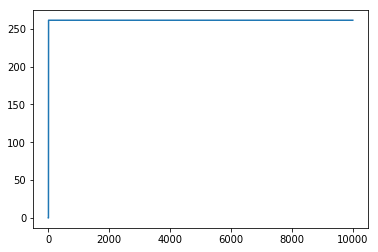

In [130]:
plt.plot(ypred)

In [122]:

popt,pcov = scipy.optimize.curve_fit(ident,df['TIC19.SV'][0:10000],data_dv['TIC19.PV'][0:10000],bounds=([-10000,0.1,0],[10000,600,100]))


ValueError: `fun` must return at most 1-d array_like.

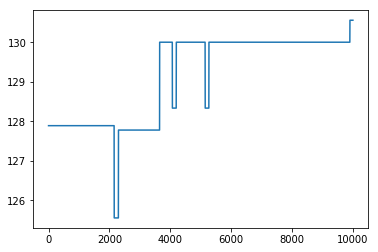

In [127]:
plt.plot(df['TIC19.SV'][0:10000])

In [102]:
popt,pcov =scipy.optimize.curve_fit(ident,df['1TC19.SP'],df['1TC19.PV'],bounds=([-10000,0.1,0],[10000,600,100]))

UnboundLocalError: local variable 'y' referenced before assignment

In [115]:
df[0:10000]

,FIC11.MV,FIC11.PV,FIC11.SV,FIC13.MV,FIC13.PV,FIC13.SV,FIC16.MV,FIC16.PV,FIC16.SV,FIC25.MV,...,PIC11.PV,PIC11.SV,PI17.PV,TIC19.MV,TIC19.PV,TIC19.SV,TI11.PV,TI13.PV,TI15.PV,TI21.PV
,BOTTOMS,BOTTOMS,BOTTOMS,FEED,FEED,FEED,HOT FLOW TO DEB REBLR,HOT FLOW TO DEB REBLR,HOT FLOW TO DEB REBLR,DISTILLATE,...,BTMS PRESS,BTMS PRESS,DB OVHD PRESSURE,TRAY 9 TEMP,TRAY 9 TEMP,TRAY 9 TEMP,OVHD TEMP D,TOP PACK T,TOWER FEED,BOTTOMS
,valve%,lit/min,lit/min,valve%,lit/min,lit/min,valve%,lit/min,lit/min,valve%,...,atm,atm,atm,valve%,deg C,deg C,deg C,deg C,deg C,deg C
0,27.9251,1568.5707,1560.550,20.7957,2207.4165,2182.125,20.0393,2941.8351,2939.5234,57.2291,...,11.2365,11.2283,11.0591,24.8004,128.2022,127.8889,63.7820,75.6067,109.5803,155.7482
1,27.9340,1561.3742,1560.550,21.0070,2166.9752,2182.125,20.1428,2937.0794,2935.3258,55.9994,...,11.1844,11.2283,11.0562,24.7662,128.2575,127.8889,63.7820,75.7186,109.5803,155.6758
2,28.4201,1533.0108,1560.550,20.7428,2205.5777,2182.125,19.8484,2956.5572,2931.1282,56.6053,...,11.2293,11.2283,11.0627,24.7292,128.3261,127.8889,63.5942,75.6067,109.5070,155.6758
3,28.7488,1551.1134,1560.550,21.1805,2154.6157,2182.125,19.6899,2939.0417,2928.3853,57.4175,...,11.2411,11.2283,11.0668,24.7157,128.3575,127.8889,63.6693,75.6067,109.5803,155.8206
4,28.3223,1576.0391,1560.550,20.7098,2203.5990,2182.125,19.3940,2944.9033,2926.8962,56.4486,...,11.2395,11.2283,11.0642,24.6948,128.3572,127.8889,63.5942,75.6067,109.5070,155.7482
5,28.5344,1559.4298,1560.550,21.0527,2170.6457,2182.125,19.7077,2880.5240,2926.5364,56.2645,...,11.2337,11.2283,11.0557,24.6928,128.3427,127.8889,63.7444,75.7558,109.6171,155.7843
6,28.4569,1564.0189,1560.550,20.6320,2208.3356,2182.125,20.0176,2916.9034,2925.4626,57.3986,...,11.2255,11.2283,11.0565,24.6794,128.3234,127.8889,63.5942,75.6067,109.5070,155.5672
7,28.6066,1547.7717,1560.550,20.9920,2172.3538,2182.125,20.1124,2921.5004,2926.3248,56.9560,...,11.2226,11.2283,11.0461,24.6883,128.3042,127.8889,63.7820,75.7186,109.5803,155.6758


In [ ]:
# ideas - consider using pandas inbuilt method to calculate the dy

In [96]:
U_int1 = interp1d(df.index,U,axis=0)

In [40]:
df- df.iloc[0,:]

,1FC11.OP,1FC11.PV,1FC11.SP,1FC13.OP,1FC13.PV,1FC13.SP,1FC16.OP,1FC16.PV,1FC16.SP,1FC25.OP,...,1PC11.PV,1PC11.SP,1PI17.PV,1TC19.OP,1TC19.PV,1TC19.SP,1TI11.PV,1TI13.PV,1TI15.PV,1TI21.PV
,DC4 BOTTOMS,DC4 BOTTOMS,DC4 BOTTOMS,DC4 FEED,DC4 FEED,DC4 FEED,HOT FLOW TO DEB REBLR,HOT FLOW TO DEB REBLR,HOT FLOW TO DEB REBLR,DC4 DISTILLATE,...,DC4 BTMS PRESS,DC4 BTMS PRESS,DB OVHD PRESSURE,DC4 TRAY 9 TEMP,DC4 TRAY 9 TEMP,DC4 TRAY 9 TEMP,DC4 OVHD TEMP D,DC4 TOP PACK T,DC4 TOWER FEED,DC4 BOTTOMS
,valve%,lit/min,lit/min,valve%,lit/min,lit/min,valve%,lit/min,lit/min,valve%,...,atm,atm,atm,valve%,deg C,deg C,deg C,deg C,deg C,deg C
0,0.0000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0089,-7.1965,0.000,0.2113,-40.4413,0.000,0.1035,-4.7557,-4.1976,-1.2297,...,-0.0521,0.0000,-0.0029,-0.0342,0.0553,0.0000,0.0000,0.1119,0.0000,-0.0724
2,0.4950,-35.5599,0.000,-0.0529,-1.8388,0.000,-0.1909,14.7221,-8.3952,-0.6238,...,-0.0072,0.0000,0.0036,-0.0712,0.1239,0.0000,-0.1878,0.0000,-0.0733,-0.0724
3,0.8237,-17.4573,0.000,0.3848,-52.8008,0.000,-0.3494,-2.7934,-11.1381,0.1884,...,0.0046,0.0000,0.0077,-0.0847,0.1553,0.0000,-0.1127,0.0000,0.0000,0.0724
4,0.3972,7.4684,0.000,-0.0859,-3.8175,0.000,-0.6453,3.0682,-12.6272,-0.7805,...,0.0030,0.0000,0.0051,-0.1056,0.1550,0.0000,-0.1878,0.0000,-0.0733,0.0000
5,0.6093,-9.1409,0.000,0.2570,-36.7708,0.000,-0.3316,-61.3111,-12.9870,-0.9646,...,-0.0028,0.0000,-0.0034,-0.1076,0.1405,0.0000,-0.0376,0.1491,0.0368,0.0361
6,0.5318,-4.5518,0.000,-0.1637,0.9191,0.000,-0.0217,-24.9317,-14.0608,0.1695,...,-0.0110,0.0000,-0.0026,-0.1210,0.1212,0.0000,-0.1878,0.0000,-0.0733,-0.1810
7,0.6815,-20.7990,0.000,0.1963,-35.0627,0.000,0.0731,-20.3347,-13.1986,-0.2731,...,-0.0139,0.0000,-0.0130,-0.1121,0.1020,0.0000,0.0000,0.1119,0.0000,-0.0724


In [23]:
fopdtmimo([[1,5,0],[2,5,0]])

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types